### Load packages

In [1]:
import os
import numpy as np
from natsort import natsorted
import seaborn as sns
import pandas as pd

import nibabel as nib
from nilearn import plotting, datasets
from nilearn.plotting import plot_anat, plot_stat_map, view_img
from nilearn.image import new_img_like, threshold_img, math_img, resample_to_img
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

### Set path to data and mask

In [2]:
#Define the path to your directory
directory_path = '../data/normal_yo_SCA/'
custom_template_path = '../data/mni_structures_job1687583.nii' 
interim_path = '../data/interim/'

### Compute medians

In [3]:
# Initialize dictionaries to hold file lists
file_groups = {
    'IXI': [],
    'Normal': [],
    'Patient': [],
    'SCA': []
}

# Iterate over files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.nii'):
        for prefix in file_groups.keys():
            if filename.startswith(prefix):
                file_groups[prefix].append(filename)
                break

In [4]:
# Function to load NIfTI files and compute the median cortical thickness for each voxel
def compute_group_median(file_list, data_dir):
    all_data = []
    for file in file_list:
        file_path = os.path.join(data_dir, file)
        img = nib.load(file_path)
        data = img.get_fdata()
        all_data.append(data)
    all_data = np.stack(all_data, axis=-1)
    median_data = np.median(all_data, axis=-1)
    return median_data

In [5]:
# Function to save median nii files
def save_nifti(data, reference_file, output_filename, data_dir, output_dir):
    reference_path = os.path.join(data_dir, reference_file)
    reference_img = nib.load(reference_path)
    new_img = nib.Nifti1Image(data, reference_img.affine)
    nib.save(new_img, output_dir+output_filename)

In [6]:
median_data_dict = {}

for group, files in file_groups.items():
    if files:  # Ensure the list is not empty
        median_data = compute_group_median(files, directory_path)
        output_filename = f'{group.lower()}_median.nii'
        save_nifti(median_data, files[0], output_filename, directory_path, "../data/interim/")
        median_data_dict[group] = median_data  # Store the median data in the dictionary
    else:
        print(f"No files found for group: {group}")



### Load median cortical thickness

In [7]:
ixi_median_data = median_data_dict.get('IXI')
normal_median_data = median_data_dict.get('Normal')
patient_median_data = median_data_dict.get('Patient')
sca_median_data = median_data_dict.get('SCA')

In [8]:
ixi_median_img = nib.load(interim_path + "ixi_median.nii")
normal_median_img = nib.load(interim_path + "normal_median.nii")
patient_median_img = nib.load(interim_path + "patient_median.nii")
sca_median_img = nib.load(interim_path + "sca_median.nii")

### Plot median cortical thickness

Plot against template

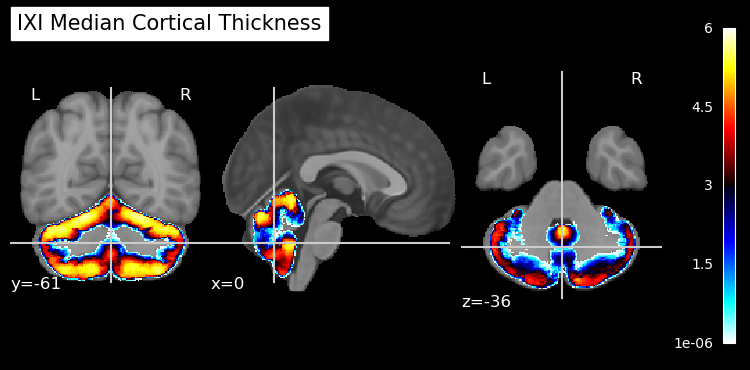

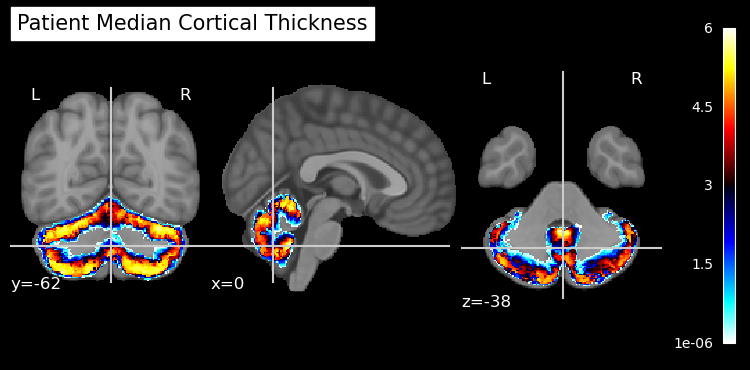

In [9]:
# Load the MNI152 template
mni152_template = datasets.load_mni152_template()

# Define a function to plot the images
def plot_median_image(img, title):
    display = plotting.plot_stat_map(
        img,
        bg_img=mni152_template,  # Background anatomical image
        title=title,
        display_mode='ortho',    # Orthogonal views: axial, sagittal, coronal
        cut_coords=None,         # Automatically determine cut coordinates
        colorbar=True,
        vmin = 0,
        vmax = 6
    )

# Plot each median image
plot_median_image(ixi_median_img, 'IXI Median Cortical Thickness')
#plot_median_image(normal_median_img, 'Normal Median Cortical Thickness')
plot_median_image(patient_median_img, 'Patient Median Cortical Thickness')
#plot_median_image(sca_median_img, 'SCA Median Cortical Thickness')

# Display the plots
plt.show()

Plot against selected labelled

In [10]:
custom_template_img = nib.load(custom_template_path)

In [11]:
def plot_median_image(img, title, bg_img):
    display = plotting.plot_stat_map(
        img,
        bg_img=None,          # Use your custom template as the background
        display_mode='ortho',   # Orthogonal views: axial, sagittal, coronal
        cut_coords=None,        # Automatically determine cut coordinates
        colorbar=True,
        vmin = 0,
        vmax = 6
    )
    display.frame_axes.set_facecolor('none')

    # Access the frame axes and title for customization
    ax = display.frame_axes

    # Set the title properties
    ax.set_title(title, fontsize=16, color='black', loc='left', backgroundcolor='none')
    plt.show()
    
    fig = display.frame_axes.figure
    fig.canvas.draw()
    fig.savefig('../results/' + title, bbox_inches='tight', dpi=300)

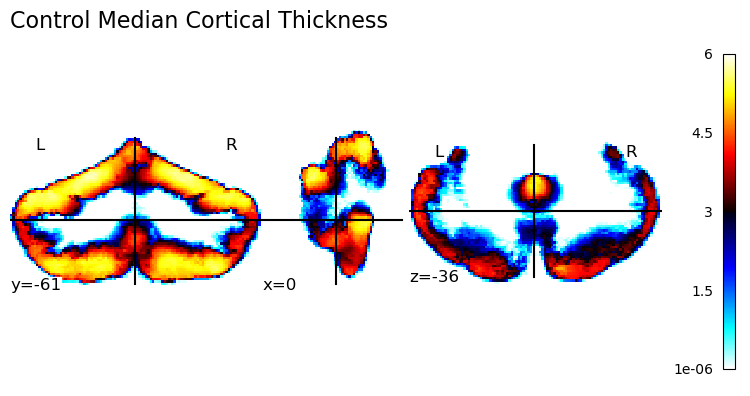

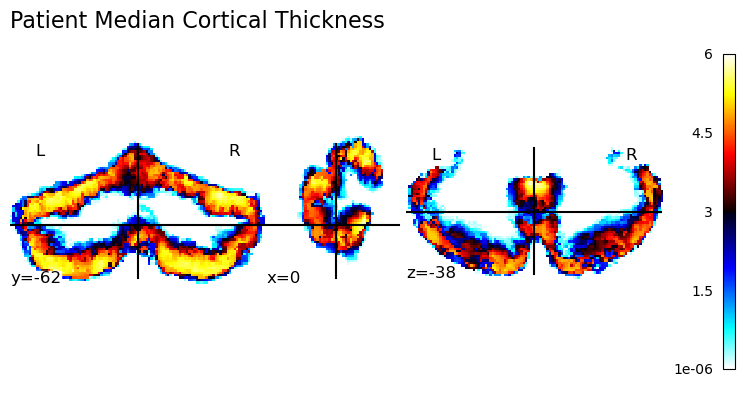

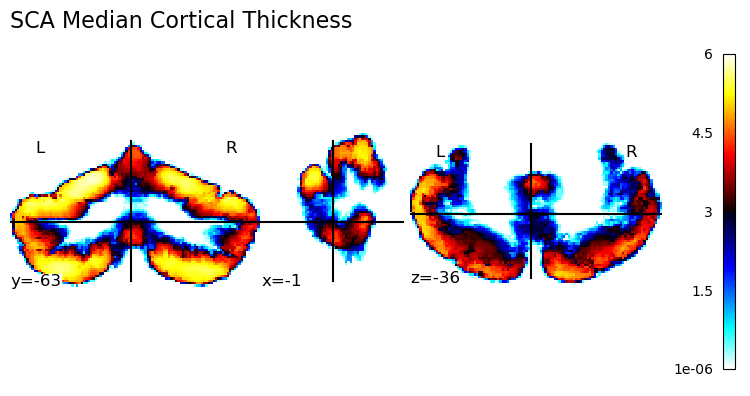

In [12]:
plot_median_image(ixi_median_img, 'Control Median Cortical Thickness', custom_template_img)
#plot_median_image(normal_median_img, 'Normal Median Cortical Thickness', custom_template_img)
plot_median_image(patient_median_img, 'Patient Median Cortical Thickness', custom_template_img)
plot_median_image(sca_median_img, 'SCA Median Cortical Thickness', custom_template_img)

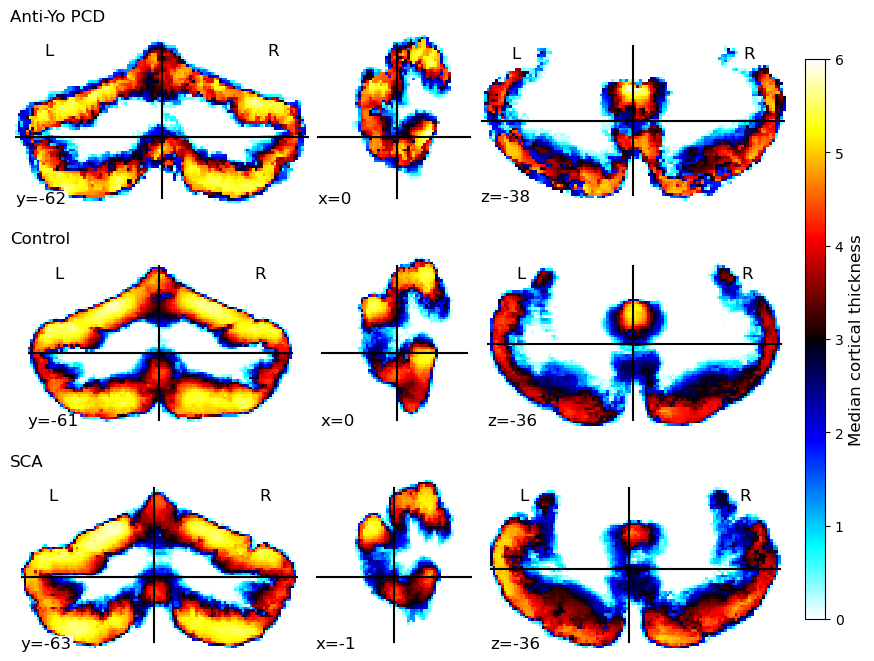

In [13]:
def plot_median_images(images, titles, bg_img, output_path):
    """
    Plots multiple statistical images vertically stacked with one shared colorbar.

    Parameters:
        images: list of 3D images (e.g., Niimg-like objects)
        titles: list of titles for each plot
        bg_img: background image for all plots
        output_path: file path to save the output image
    """
    # Create a figure with subplots
    n_plots = len(images)
    fig, axes = plt.subplots(
        nrows=n_plots, 
        ncols=1, 
        figsize=(10, 8),  # Adjusted for better aspect ratio
        gridspec_kw={"height_ratios": [1] * n_plots, "hspace": 0.3}  # Adjust spacing between plots
    )

    # Define color scaling for all plots
    vmin = 0
    vmax = 6
    cmap = 'cold_hot'

    for idx, (img, title) in enumerate(zip(images, titles)):
        # Use the corresponding axes for each plot
        display = plotting.plot_stat_map(
            img,
            bg_img=bg_img,
            display_mode='ortho',
            cut_coords=None,
            colorbar=False,  # We'll add one shared colorbar manually
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
            axes=axes[idx],  # Use the specific axis for this subplot
        )
        # Add the title to the corresponding subplot
        axes[idx].set_title(title, fontsize=12, color='black', loc='left', pad=10)

        # Remove the background for transparency
        display.frame_axes.set_facecolor('none')

    # Add a shared colorbar
    # Manually create a colorbar
    norm = Normalize(vmin=vmin, vmax=vmax)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust position: [left, bottom, width, height]
    cbar = ColorbarBase(cbar_ax, cmap=plt.get_cmap(cmap), norm=norm, orientation='vertical')
    cbar.set_label('Median cortical thickness')  # Add a label for the colorbar
    cbar.ax.yaxis.label.set_size(12)  # Set label font size

    # Save the figure to the specified output path
    plt.savefig(output_path, bbox_inches='tight', dpi=300)

# Example usage:
images = [patient_median_img, ixi_median_img, sca_median_img]
titles = ['Anti-Yo PCD', 
          'Control', 
          'SCA']
custom_template_img = None

plot_median_images(images, titles, custom_template_img, '../results/Median_Cortical_Thickness.svg')


### Load 4D

In [14]:
def load_thickness_data(file_list):
    all_data = []
    for file in file_list:
        img = nib.load(directory_path+file)
        data = img.get_fdata()
        all_data.append(data)
    return np.stack(all_data, axis=-1)

# Dictionary to hold stacked data for each group
group_data = {}

for group, files in file_groups.items():
    if files:  # Ensure the list is not empty
        group_data[group] = load_thickness_data(files)
    else:
        print(f"No files found for group: {group}")

# Ensure that the data arrays are 4D (with the last dimension representing subjects)
assert group_data['IXI'].ndim == 4, "Data for disease group should be 4D"
assert group_data['Normal'].ndim == 4, "Data for disease group should be 4D"
assert group_data['Patient'].ndim == 4, "Data for disease group should be 4D"
assert group_data['SCA'].ndim == 4, "Data for disease group should be 4D"

### Apply area mask

In [15]:
labels_mask_img = nib.load(custom_template_path)
labels_mask_data = labels_mask_img.get_fdata()

In [16]:
# Define the labels
labels = {
    1: 'Lobule I-II',
    2: 'Lobule III',
    3: 'Lobule IV',
    4: 'Lobule V',
    5: 'Lobule VI',
    6: 'Lobule Crus I',
    7: 'Lobule Crus II',
    8: 'Lobule VIIB',
    9: 'Lobule VIIIA',
    10: 'Lobule VIIIB',
    11: 'Lobule IX',
    12: 'Lobule X',
    101: 'Lobule I-II (R)',
    102: 'Lobule III (R)',
    103: 'Lobule IV (R)',
    104: 'Lobule V (R)',
    105: 'Lobule VI (R)',
    106: 'Lobule Crus I (R)',
    107: 'Lobule Crus II (R)',
    108: 'Lobule VIIB (R)',
    109: 'Lobule VIIIA (R)',
    110: 'Lobule VIIIB (R)',
    111: 'Lobule IX (R)',
    112: 'Lobule X (R)'
}

# Create a colormap for the labels
num_labels = len(labels)
colors = plt.cm.jet(np.linspace(0, 1, num_labels))
cmap = ListedColormap(colors)

In [17]:
# Create a NIfTI image to resample mask
sample_img = nib.load(directory_path+file_groups['IXI'][0])

In [18]:
# Ensure the labels mask is registered to the same space 
resampled_labels_mask_img = resample_to_img(labels_mask_img, sample_img, interpolation='nearest')
resampled_labels_mask_data = resampled_labels_mask_img.get_fdata()

/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_38808/3739357662.py:2: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_labels_mask_img = resample_to_img(labels_mask_img, sample_img, interpolation='nearest')
/Users/tamara/anaconda3/envs/pcdanalysis/lib/python3.11/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


In [19]:
area_masks = {} 

for label, region_name in labels.items():
    # Create a mask for the current region
    area_masks[label] = resampled_labels_mask_data == label

In [20]:
median_thickness_all_groups = {}

# Iterate over each group in group_data
for group, data in group_data.items():
    n_subjects = data.shape[-1]  # Number of subjects in this group

    # Initialize the dictionary for storing median thickness per area for this group
    median_thickness_per_area = {area: [] for area in area_masks.keys()}

    # Iterate over each subject and calculate median thickness per area
    for subject_idx in range(n_subjects):
        subject_data = data[..., subject_idx]  # Extract data for the subject (shape: X, Y, Z)

        for area, mask in area_masks.items():
            # Apply the mask to the subject's data
            masked_data = subject_data[mask]  # Extract values for the specific area

            # Calculate the median thickness for this area and this subject
            median_thickness = np.median(masked_data)

            # Store the median thickness in the dictionary
            median_thickness_per_area[area].append(median_thickness)

    # Store the per-area median thickness data for this group
    median_thickness_all_groups[group] = median_thickness_per_area



### Discard group "normal"

In [21]:
# Discard the "Normal" group
median_thickness_all_groups.pop('Normal', None)

{1: [0.8066657483577728,
  0.1793530434370041,
  0.0,
  0.04759933240711689,
  3.7754900455474854,
  1.0557860136032104,
  0.0,
  0.0,
  2.7355802059173584,
  0.08610812202095985,
  0.0,
  2.820706367492676,
  0.014150193193927407],
 2: [1.0117692351341248,
  0.8308950960636139,
  0.0,
  3.784674481721595e-05,
  3.653432846069336,
  0.11126911640167236,
  0.0,
  0.0,
  3.12972092628479,
  0.8367175757884979,
  0.0007436469895765185,
  1.5691834092140198,
  0.0],
 3: [4.224420070648193,
  4.126785516738892,
  0.9466874301433563,
  1.4917036890983582,
  5.1082940101623535,
  4.803174734115601,
  4.70775294303894,
  0.053431905806064606,
  4.416953086853027,
  4.818094253540039,
  1.250444769859314,
  4.873952388763428,
  4.846573352813721],
 4: [4.987729072570801,
  4.880847454071045,
  1.271486759185791,
  1.1371538639068604,
  5.352380752563477,
  5.080404758453369,
  5.382391452789307,
  0.15461742877960205,
  4.804201602935791,
  5.173876762390137,
  1.4216532707214355,
  5.112695217

### Dimensionality_reduction

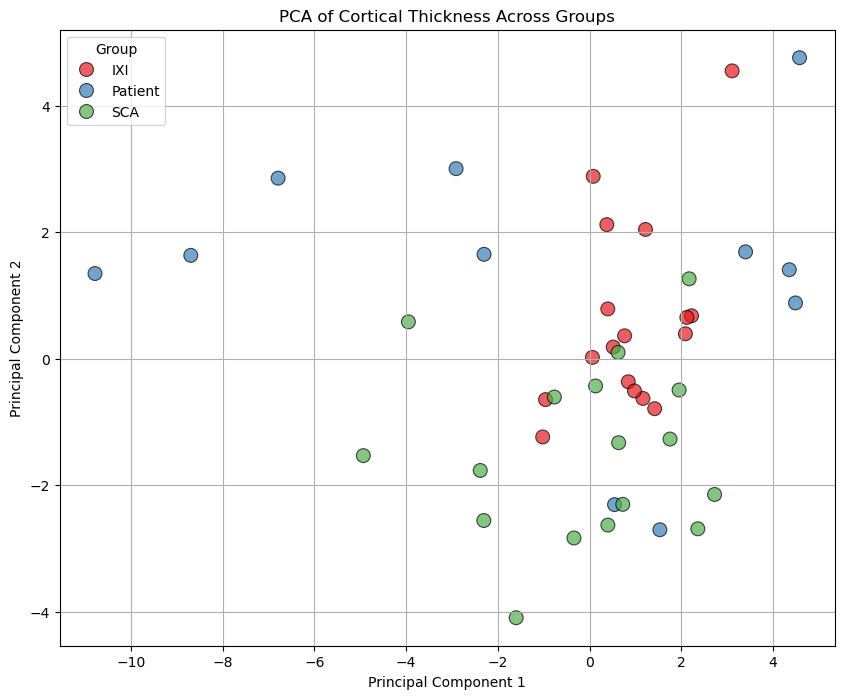

Explained Variance by Component: [0.40709344 0.16231211]


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Prepare the data for PCA
# Assuming `median_thickness_all_groups` is a dictionary where each group contains the median thickness for each area
# We need to flatten this into a table-like structure

data_for_pca = []
group_labels = []

# Create a flattened data structure for PCA
for group, areas in median_thickness_all_groups.items():
    for subject_idx in range(len(list(areas.values())[0])):  # Iterate through the number of subjects in each group
        subject_data = []
        for area in areas.keys():
            subject_data.append(areas[area][subject_idx])  # Get the median thickness for this subject in the current area
        data_for_pca.append(subject_data)
        group_labels.append(group)

# Convert to DataFrame
columns = list(median_thickness_all_groups['Patient'].keys())  # Use the lobule names as column names
df = pd.DataFrame(data_for_pca, columns=columns)
df['Group'] = group_labels

# Separate features and labels
X = df.drop('Group', axis=1)  # Features (cortical thickness values)
y = df['Group']  # Labels (group names)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
n_components = 2  # Number of principal components you want to keep for visualization purposes
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
principal_df['Group'] = y

# Visualize the PCA result
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2', hue='Group', data=principal_df, palette='Set1', s=100, alpha=0.7, edgecolor='k'
)
plt.title('PCA of Cortical Thickness Across Groups')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained Variance by Component: {explained_variance}')


### Plotting

In [23]:
# Prepare data for plotting in a long format
data = []

# Iterate over the meamediann thickness data for each group and expand the lists into individual rows
for group, thickness_data in median_thickness_all_groups.items():
    # Set the condition label appropriately
    condition = group
    #condition = 'Control+IXI' if group == 'Normal' else ('SCA' if group == 'SCA' else 'Anti-Yo')

    for label, thickness_list in thickness_data.items():
        # Determine if the lobe is 'Left' or 'Right' based on the label
        lobe = 'Left' if label < 100 else 'Right'
        
        # Expand each thickness value into individual rows
        for patient_idx, thickness in enumerate(thickness_list):
            data.append({
                'Lobe': lobe,
                'Label': label,
                'Condition': condition,
                'Thickness': thickness,
                'Patient': condition + " " + str(patient_idx + 1),
            })

# Convert to DataFrame
df = pd.DataFrame(data)

In [24]:
# Perform the statistical tests
statistical_results = []

# Iterate over each area in the area_masks
for area in area_masks.keys():
    # Extract data for 'Patient' and 'Control' groups for the current area
    patient_data = median_thickness_all_groups['Patient'][area]
    control_data = median_thickness_all_groups['IXI'][area]
    sca_data = median_thickness_all_groups['SCA'][area]

    # Append the t-statistic and one-sided p-value to the results list
    statistical_results.append({
        'Area': area,
        'ixi median thickness': np.median(control_data),
        'patient median thickness': np.median(patient_data),
        'sca median thickness': np.median(sca_data)

    })

# Convert the results to a DataFrame
stats_df = pd.DataFrame(statistical_results)
stats_df['Area Name'] = stats_df['Area'].map(labels)

print(stats_df.head())

   Area  ixi median thickness  patient median thickness  sca median thickness  \
0     1              1.479226                  0.064694              0.561410   
1     2              2.058685                  1.784195              1.732671   
2     3              4.598509                  3.118885              4.748646   
3     4              4.752987                  4.035964              5.019249   
4     5              4.782900                  4.177687              4.779464   

     Area Name  
0  Lobule I-II  
1   Lobule III  
2    Lobule IV  
3     Lobule V  
4    Lobule VI  


In [25]:
median_thickness_data_ixi = np.zeros(resampled_labels_mask_data.shape)

# Iterate over the statistical results DataFrame
for _, row in stats_df.iterrows():
    label_value = row['Area']
    thickness_value = row['ixi median thickness']

    # Update the t-stat map: assign the t-statistic value to the corresponding area label
    # Only update the specific voxels corresponding to this region
    median_thickness_data_ixi[resampled_labels_mask_data == label_value] = thickness_value

# Create a new NIfTI image from the significant t-stat map data
affine = labels_mask_img.affine  # Get the affine from the original label mask
median_thickness_img_ixi = nib.Nifti1Image(median_thickness_data_ixi, affine)

In [26]:
median_thickness_data_patient = np.zeros(resampled_labels_mask_data.shape)

# Iterate over the statistical results DataFrame
for _, row in stats_df.iterrows():
    label_value = row['Area']
    thickness_value = row['patient median thickness']

    # Update the t-stat map: assign the t-statistic value to the corresponding area label
    # Only update the specific voxels corresponding to this region
    median_thickness_data_patient[resampled_labels_mask_data == label_value] = thickness_value

# Create a new NIfTI image from the significant t-stat map data
affine = labels_mask_img.affine  # Get the affine from the original label mask
median_thickness_img_patient = nib.Nifti1Image(median_thickness_data_patient, affine)

In [27]:
median_thickness_data_sca = np.zeros(resampled_labels_mask_data.shape)

# Iterate over the statistical results DataFrame
for _, row in stats_df.iterrows():
    label_value = row['Area']
    thickness_value = row['sca median thickness']

    # Update the t-stat map: assign the t-statistic value to the corresponding area label
    # Only update the specific voxels corresponding to this region
    median_thickness_data_sca[resampled_labels_mask_data == label_value] = thickness_value

# Create a new NIfTI image from the significant t-stat map data
affine = labels_mask_img.affine  # Get the affine from the original label mask
median_thickness_img_sca = nib.Nifti1Image(median_thickness_data_sca, affine)

In [28]:
# Add a default label for unexpected values
default_label = 'Unknown'

# Extract the coordinates for each label
coords = np.argwhere(resampled_labels_mask_data > 0)
coords_labels = [labels.get(int(resampled_labels_mask_data[tuple(coord)]), default_label) for coord in coords]

# Create an interactive 3D plot using plotly
fig = px.scatter_3d(
    x=coords[:, 0], y=coords[:, 1], z=coords[:, 2], 
    color=coords_labels, labels={'color': 'Lobule'}, 
    title='Interactive Cerebellar Labels'
)

# Update the layout to show labels on hover
fig.update_traces(marker=dict(size=3), selector=dict(mode='markers'))

fig.show()

#fig.write_html("brain_regions.html")

In [29]:
# Extract data arrays and affine
ixi_data = median_thickness_img_ixi.get_fdata()
affine_ixi = median_thickness_img_ixi.affine

patient_data = median_thickness_img_patient.get_fdata()
affine_patient = median_thickness_img_patient.affine

sca_data = median_thickness_img_sca.get_fdata()
affine_sca = median_thickness_img_sca.affine

# Map coordinates to real-world space
significant_voxels_ixi = np.where(ixi_data != 0)
significant_coords_ixi = nib.affines.apply_affine(affine_ixi, np.vstack(significant_voxels_ixi).T)

significant_voxels_patient = np.where(patient_data != 0)
significant_coords_patient = nib.affines.apply_affine(affine_patient, np.vstack(significant_voxels_patient).T)

significant_voxels_sca = np.where(sca_data != 0)
significant_coords_sca = nib.affines.apply_affine(affine_sca, np.vstack(significant_voxels_sca).T)

# Normalize intensities across datasets for a shared range
norm = Normalize(vmin=np.min([ixi_data.min(), patient_data.min(), sca_data.min()]),
                 vmax=np.max([ixi_data.max(), patient_data.max(), sca_data.max()]))

# Create DataFrames for easier plotting
df_patient = pd.DataFrame({
    'x': significant_coords_patient[:, 0],
    'y': significant_coords_patient[:, 1],
    'z': significant_coords_patient[:, 2],
    'Thickness': patient_data[significant_voxels_patient]
})

df_ixi = pd.DataFrame({
    'x': significant_coords_ixi[:, 0],
    'y': significant_coords_ixi[:, 1],
    'z': significant_coords_ixi[:, 2],
    'Thickness': ixi_data[significant_voxels_ixi]
})

df_sca = pd.DataFrame({
    'x': significant_coords_sca[:, 0],
    'y': significant_coords_sca[:, 1],
    'z': significant_coords_sca[:, 2],
    'Thickness': sca_data[significant_voxels_sca]
})

In [30]:
# Load the lobular labels (for anterior/posterior analysis)
coords_labels = np.argwhere(resampled_labels_mask_data > 0)
labels_dict = {
    1: 'Lobule I-II',
    2: 'Lobule III',
    3: 'Lobule IV',
    4: 'Lobule V',
    5: 'Lobule VI',
    6: 'Lobule Crus I',
    7: 'Lobule Crus II',
    8: 'Lobule VIIB',
    9: 'Lobule VIIIA',
    10: 'Lobule VIIIB',
    11: 'Lobule IX',
    12: 'Lobule X',
    101: 'Lobule I-II (R)',
    102: 'Lobule III (R)',
    103: 'Lobule IV (R)',
    104: 'Lobule V (R)',
    105: 'Lobule VI (R)',
    106: 'Lobule Crus I (R)',
    107: 'Lobule Crus II (R)',
    108: 'Lobule VIIB (R)',
    109: 'Lobule VIIIA (R)',
    110: 'Lobule VIIIB (R)',
    111: 'Lobule IX (R)',
    112: 'Lobule X (R)',
}
valid_coords = []
valid_labels = []

for coord in coords_labels:
    label_value = int(resampled_labels_mask_data[tuple(coord)])
    if label_value in labels_dict:  # Only map if it's a valid label
        valid_coords.append(coord)
        valid_labels.append(labels_dict[label_value])

# Create DataFrame for valid points only
df_labels = pd.DataFrame({
    'x': np.array(valid_coords)[:, 0],
    'y': np.array(valid_coords)[:, 1],
    'z': np.array(valid_coords)[:, 2],
    'Label': valid_labels
})

df_labels['Category'] = df_labels['Label'].apply(lambda x: 'Anterior' if 'I-II' in x or 'III' in x  or 'IV' in x or 'V' in x else 'Posterior')


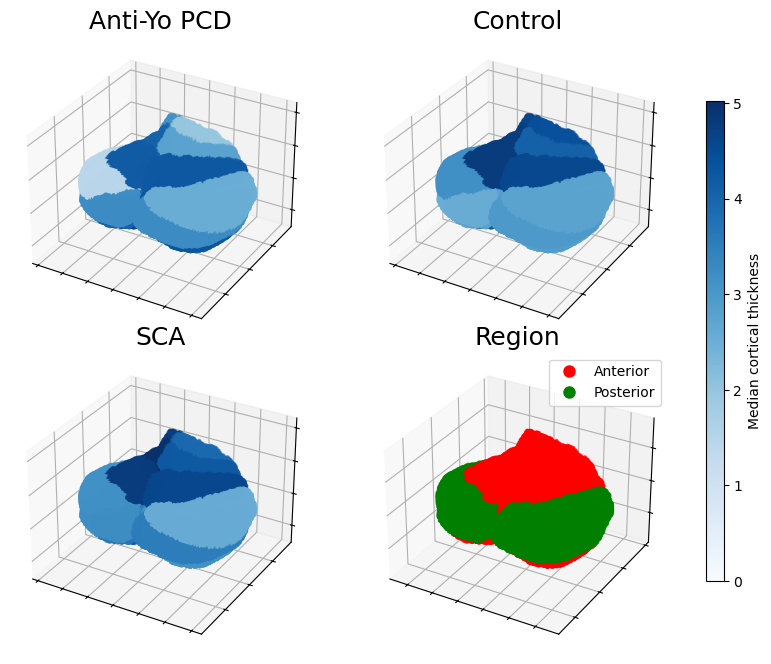

In [31]:
# Create matplotlib 2x2 subplots
fig, axes = plt.subplots(
    2, 
    2, 
    figsize=(9, 8),
    #constrained_layout=True,
    subplot_kw={"projection": "3d"}
)

fig.subplots_adjust(wspace=0.05, hspace=0.05)

# Plot the Patient Data
p_patient = axes[0, 0].scatter(
    df_patient['x'], df_patient['y'], df_patient['z'], 
    c=df_patient['Thickness'], cmap='Blues', s=5, norm=norm
)
axes[0, 0].set_title('Anti-Yo PCD', fontsize=18)
axes[0, 0].set_xticklabels([])
axes[0, 0].set_yticklabels([])
axes[0, 0].set_zticklabels([])

# Plot the IXI Data
p_ixi = axes[0, 1].scatter(
    df_ixi['x'], df_ixi['y'], df_ixi['z'], 
    c=df_ixi['Thickness'], cmap='Blues', s=5, norm=norm
)
axes[0, 1].set_title('Control', fontsize=18)
axes[0, 1].set_xticklabels([])
axes[0, 1].set_yticklabels([])
axes[0, 1].set_zticklabels([])

# Plot the SCA Data
p_sca = axes[1, 0].scatter(
    df_sca['x'], df_sca['y'], df_sca['z'], 
    c=df_sca['Thickness'], cmap='Blues', s=5, norm=norm
)
axes[1, 0].set_title('SCA', fontsize=18)
axes[1, 0].set_xticklabels([])
axes[1, 0].set_yticklabels([])
axes[1, 0].set_zticklabels([])


# Anterior vs Posterior plot
categories = df_labels['Category'].map({'Anterior': 'red', 'Posterior': 'green'})
sc = axes[1, 1].scatter(
    df_labels['x'], df_labels['y'], df_labels['z'], 
    c=categories, s=5,
)
axes[1, 1].set_title('Region', fontsize=18)
axes[1, 1].set_xticklabels([])
axes[1, 1].set_yticklabels([])
axes[1, 1].set_zticklabels([])

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Move colorbar further to the right
fig.colorbar(p_patient, cax=cbar_ax, label='Median cortical thickness')

# Add legend for anterior/posterior
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Anterior'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Posterior')
]
axes[1, 1].legend(handles=handles, loc='upper right')

# Save and show plot
plt.savefig('../results/stacked_2x2_annotated_legend.svg', bbox_inches='tight', dpi=150)
plt.show()